In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
# import pygraphviz as viz
import networkx as nx
import pandas as pd
import random
import numpy as np
from utils.draw import draw_graph, draw_partition, draw_partition2, draw_partition3

In [3]:
'''This function places the graph into a breadth-first structure'''
def breadth_first(graph, root):
    n = graph.shape[0]
    
    new_graph = -np.ones((n, n))
    level = -np.ones(n,int)
    nodes = np.array(range(n))#номера вершин для удобства
    
    current_level = 0
    
    level[root] = current_level
    
    while current_level in level:
        for node in nodes[level == current_level]:#не в тот массив смотрели(нужны были номера вершин!)
            
            index = nodes[ (graph[node]>=0) & (level == -1)]
                  
            new_graph[node,index] = 0
            
            new_graph[index,node] = 0
                
            level[index] = current_level + 1
            
        current_level += 1
    return new_graph, level

In [4]:
graph = np.array([[0, 1., 1., 0, 0],
       [1., 0, 1., 0, 0],
       [1., 1., 0, 1., 0],
       [0, 0, 1., 0, 1.],
       [0, 0, 0, 1., 0]])

In [5]:
graph[graph == 0] = -1

In [6]:
graph[graph>0] = 0

In [7]:
graph

array([[-1.,  0.,  0., -1., -1.],
       [ 0., -1.,  0., -1., -1.],
       [ 0.,  0., -1.,  0., -1.],
       [-1., -1.,  0., -1.,  0.],
       [-1., -1., -1.,  0., -1.]])

In [8]:
root = 0

In [9]:
new_graph, level = breadth_first(graph,root)

In [10]:
new_graph

array([[-1.,  0.,  0., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1.,  0., -1.],
       [-1., -1.,  0., -1.,  0.],
       [-1., -1., -1.,  0., -1.]])

In [11]:
list(range(int(level.max()+1)))

[0, 1, 2, 3]

breadth_first - вроде исправил

In [12]:
'''This function calculates the values of the shortest paths to each node (shortest path = the sum of incoming paths)'''
def pointer(new_graph, level, root):
    
    n = new_graph.shape[0]
    output = np.zeros(n)
    output[root] = 1
    nodes = np.array(range(n))#номера вершин для удобства
    
    for x in range(int(level.max()+1)):
        for y in nodes[level == x]: #upside down #не в тот массив смотрели(нужны были номера вершин!)
            
            index = nodes[(new_graph[y] >= 0) & (level == x+1)]
            

            output[index] += output[y]
    
    
    return output

In [13]:
output = pointer(new_graph, level, root)

In [14]:
np.array(range(np.max(level)+1)[::-1])

array([3, 2, 1, 0])

In [15]:
output

array([1., 1., 1., 1., 1.])

In [16]:
level

array([0, 1, 1, 2, 3])

In [17]:
list(level).index(2)

3

pointer - вроде исправил (нужна проверка на более больших графах)

In [18]:
''' Determine the flow values from a starting node A to all other nodes in the network. 
This is done by working up from the lowest layers of the breadth-first search and dividing up the flow above a node 
in proportion to the number of shortest paths coming into it on each edge.'''
def flow(new_graph, level, root, output):
    
    n = new_graph.shape[0]
    nodes = np.array(range(n))#номера вершин для удобства
    flows = np.ones(n)
    
    for x in np.array(range(np.max(level)+1)[::-1]):
        for y in nodes[level == x]:  #не в тот массив смотрели(нужны были номера вершин!)
            for i in nodes[(new_graph[y] >= 0) & (level == x-1)]:
                new_graph[i][y] = flows[y] * output[i] / output[y]
                new_graph[y][i] = flows[y] * output[i] / output[y]
                flows[i] += flows[y] * output[i] / output[y]

    return new_graph

In [19]:
new_graph

array([[-1.,  0.,  0., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1.,  0., -1.],
       [-1., -1.,  0., -1.,  0.],
       [-1., -1., -1.,  0., -1.]])

In [20]:
flow(new_graph, level, root, output)

array([[-1.,  1.,  3., -1., -1.],
       [ 1., -1., -1., -1., -1.],
       [ 3., -1., -1.,  2., -1.],
       [-1., -1.,  2., -1.,  1.],
       [-1., -1., -1.,  1., -1.]])

flow - вроде исправил (нужна проверка на более больших графах)

In [21]:
def removeEdge(graph):
    max_edge = graph.max()
    graph[graph == max_edge] = -1       
    return graph

In [22]:
def summary(graph,iterations):
    output = []
    graph[graph >= 0] = 0
    
    for y in range(iterations):

        for x in tqdm(range(graph.shape[0])):
            root = x

            breadth_first_value = breadth_first(graph, root)
            
            node_values = pointer(breadth_first_value[0], breadth_first_value[1], root)
            
            
            flow_values = flow(
                breadth_first_value[0],
                breadth_first_value[1],
                root,
                node_values)

            graph[flow_values >= 0] += flow_values[flow_values >= 0]

        graph = removeEdge(graph)
        graph[graph >= 0] = 0
        output.append(graph.copy())#Делаем копию
    return output

Практика

In [30]:
df = pd.read_csv('vk_links.csv')

In [31]:
users = set(df['out_f']).union(set(df['in_f']))

users = list(users)
index = np.array(range(len(users)))

graph = -np.ones((491,491))

for idx, row in df.iterrows():
    
    index1 = users.index(row['out_f'])
    index2 = users.index(row['in_f'])
    
    graph[index1][index2] = 0
    graph[index2][index1] = 0

In [32]:
def convert(graph):
    G = nx.Graph()
    G.add_nodes_from(list(range(graph.shape[0])))
    
    for x in range(graph.shape[0]):
        for y in range(x, graph.shape[0]):
            if graph[x][y] == 0:
                G.add_edge(x, y)
    return G

In [33]:
G = convert(graph)

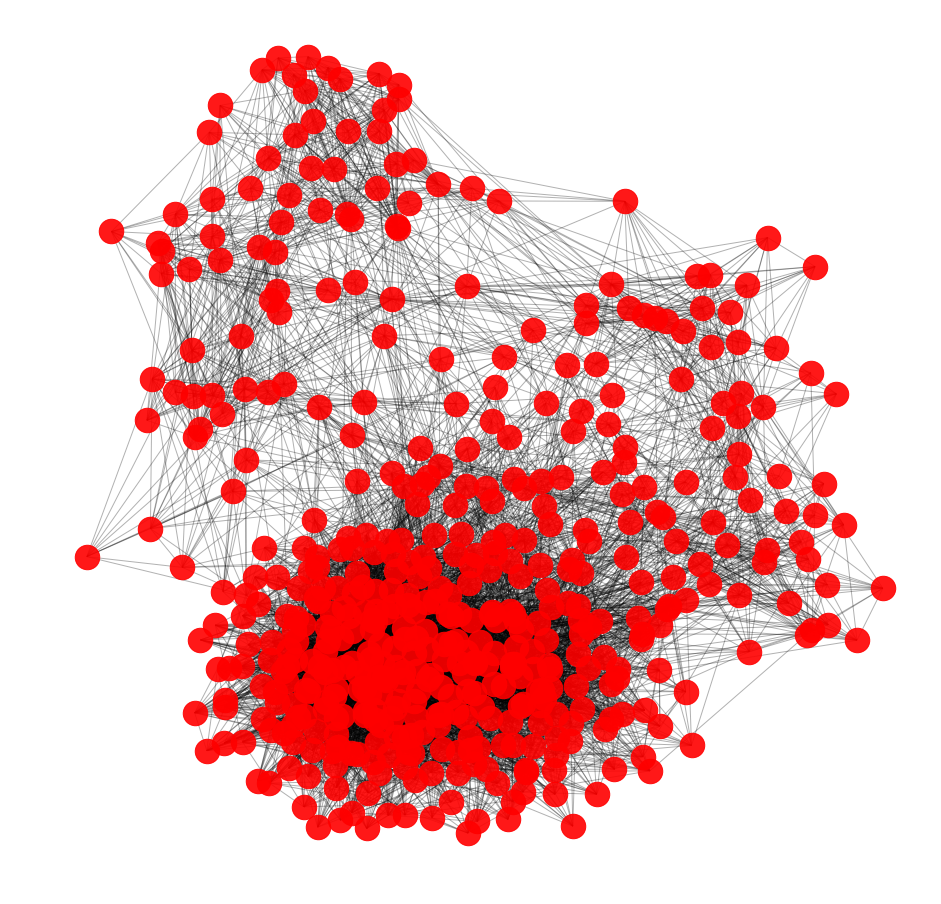

In [34]:
draw_graph(G) 

In [35]:
result = summary(graph,1000)

100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:06<00:00, 77.99it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:06<00:00, 74.23it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:06<00:00, 72.39it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 92.89it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 94.55it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 102.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 102.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:03<00:00, 125.24it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:03<00:00, 127.54it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 118.76it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 84.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 89.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 99.57it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 491/491 [00:04<00:00, 113.02it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 491/491 [00:05<00:00, 96.74it/s]


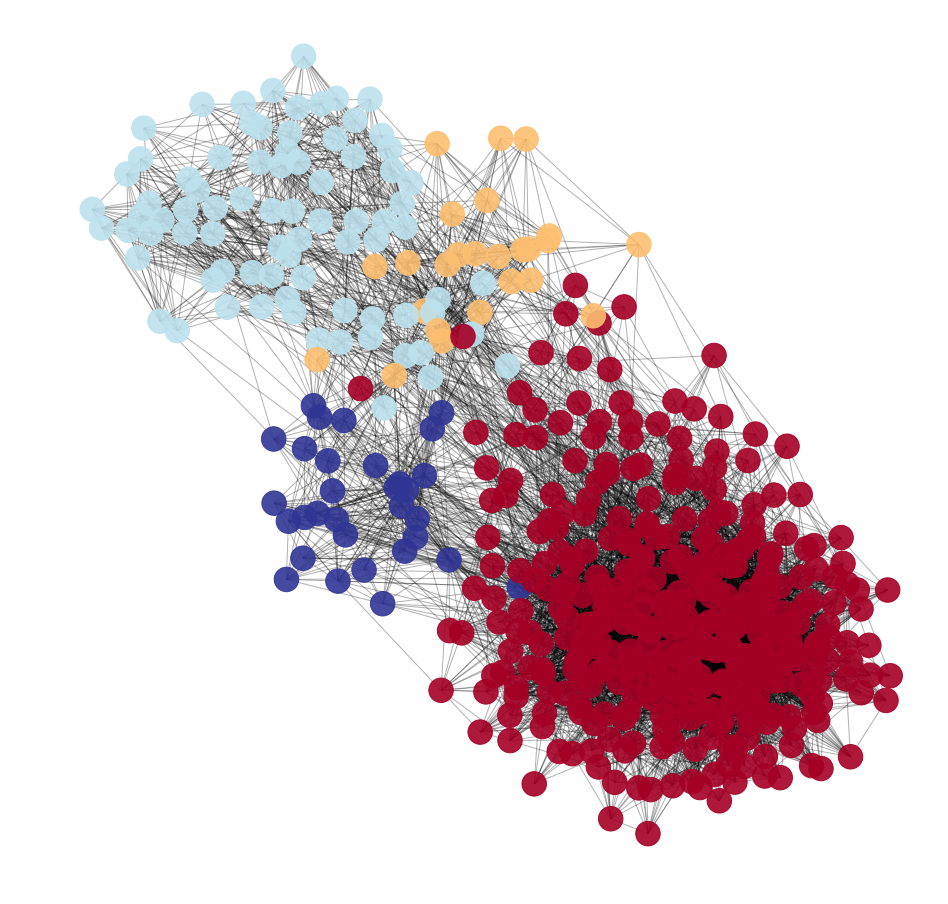

In [48]:
draw_partition2(convert(result[0]),categorize(result[510]))

In [51]:
 abc = categorize(result[99])

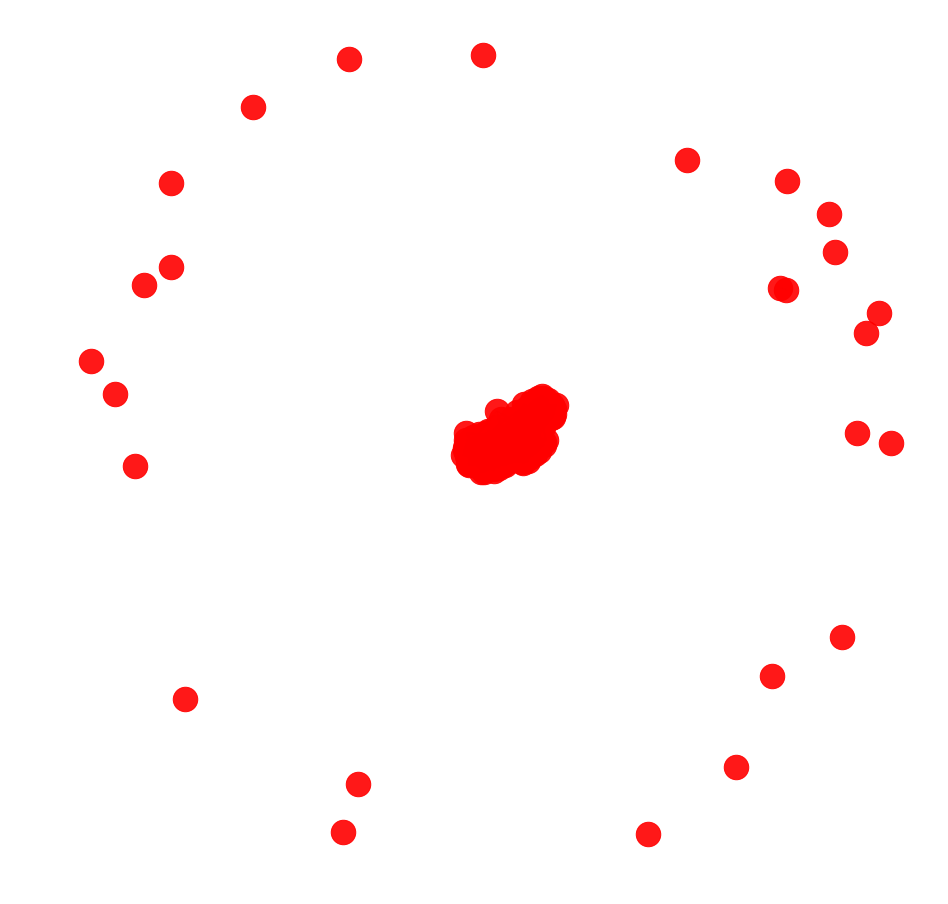

In [63]:
draw_graph(convert(result[250])) 

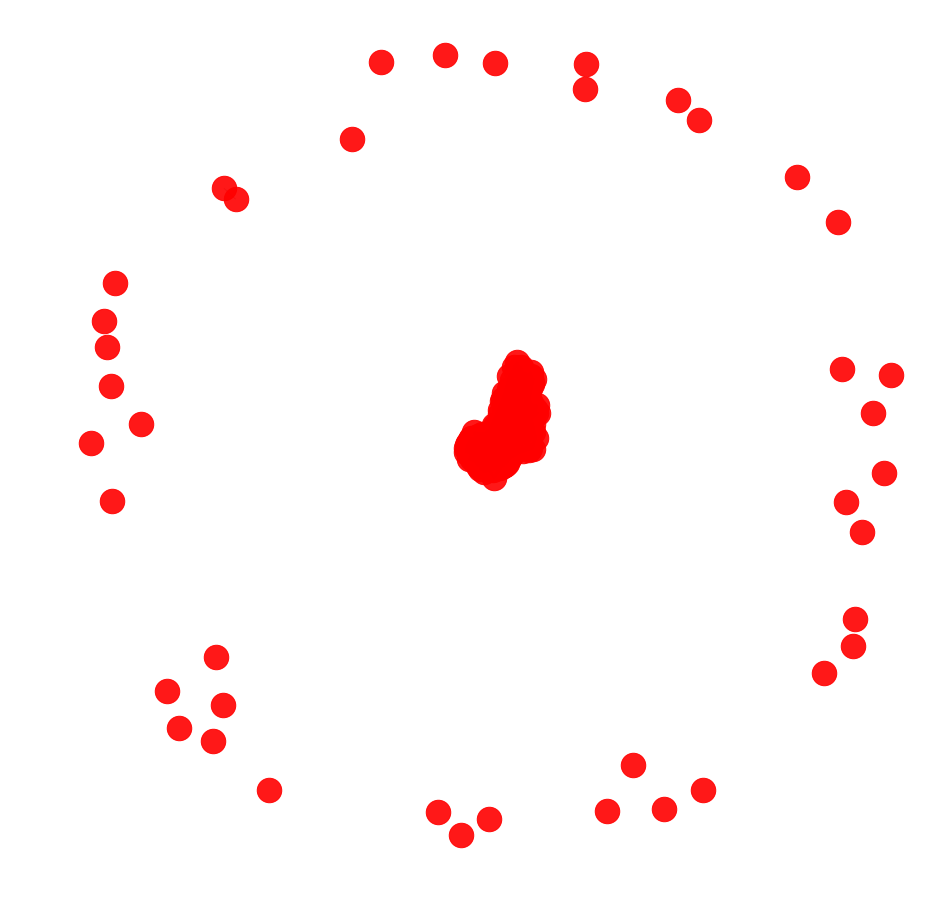

In [64]:
draw_graph(convert(result[500]))

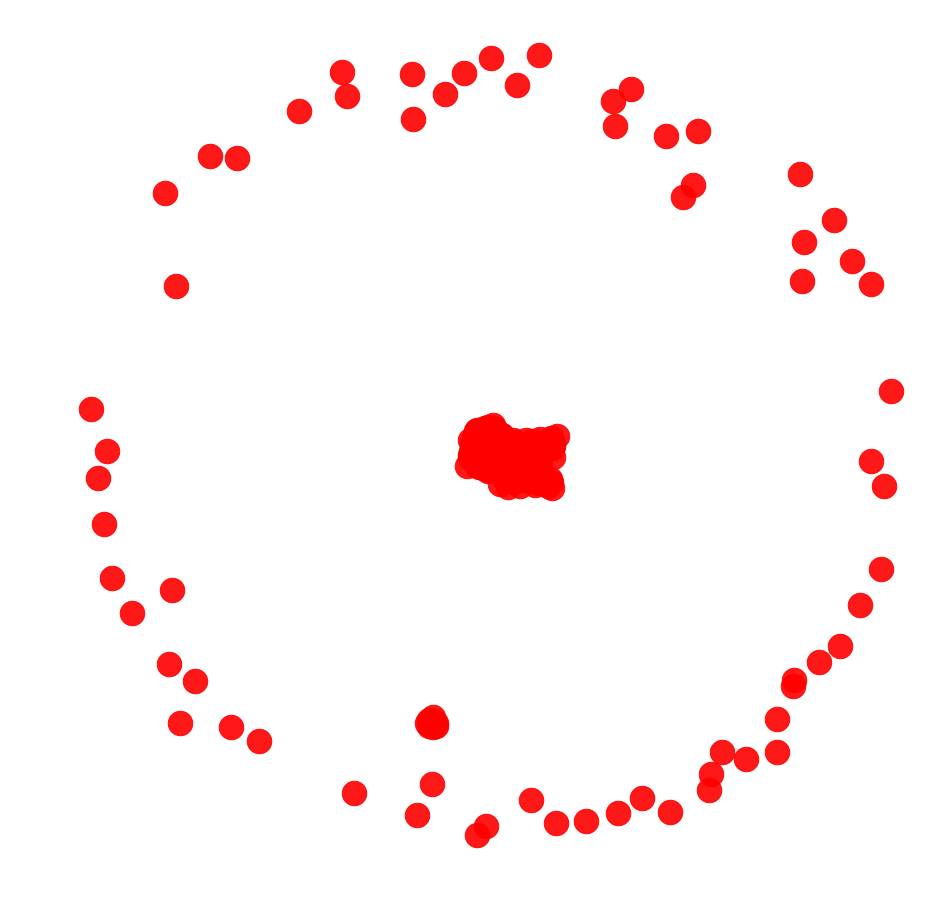

In [65]:
draw_graph(convert(result[750]))

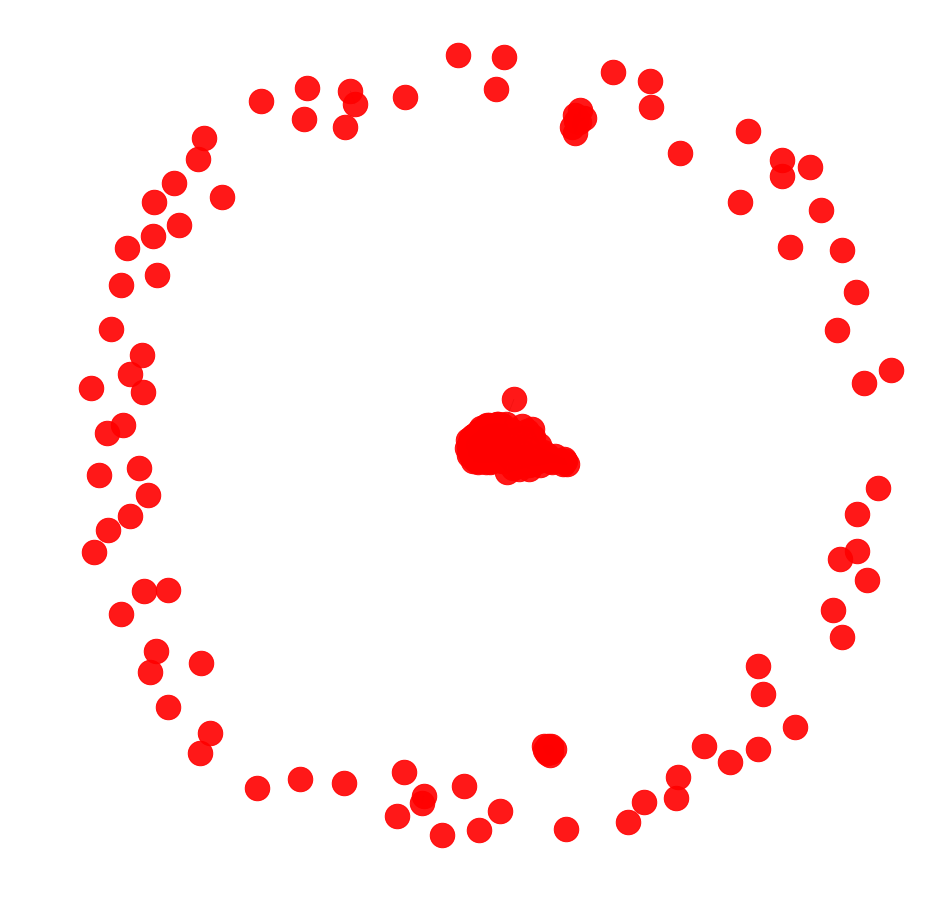

In [66]:
draw_graph(convert(result[999]))

In [42]:
 abc = categorize(result[999])

NameError: name 'result' is not defined

In [58]:
graph_1 = np.array([[-1, 0,  0, -1, -1, -1, -1, -1, -1, -1, -1], #1
                    [ 0, -1, 0,  0,  0, -1, -1, -1, -1, -1, -1],  #2
                    [ 0, 0, -1,  0,  0, -1, -1, -1, -1, -1, -1],  #3
                    [-1,  0,  0, -1, 0, -1, -1, -1, -1, -1, -1],  #4
                    [-1,  0,  0,  0, -1,  0, -1, -1, -1, -1, -1],  #5
                    [-1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1],  #6
                    [-1, -1, -1, -1,  -1,  0, -1,  0,  0,  0, -1],  #7
                    [-1, -1, -1, -1, -1, -1,  0, -1,  0,  0, -1],  #8
                    [-1, -1, -1, -1, -1, -1,  0,  0, -1, 0,  0],  #9
                    [-1, -1, -1, -1, -1, -1,  0,  0,  0,  -1,  0],  #10
                    [-1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1]],float)  #11

In [59]:
res = summary(graph_1,5)

100%|████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1949.52it/s]


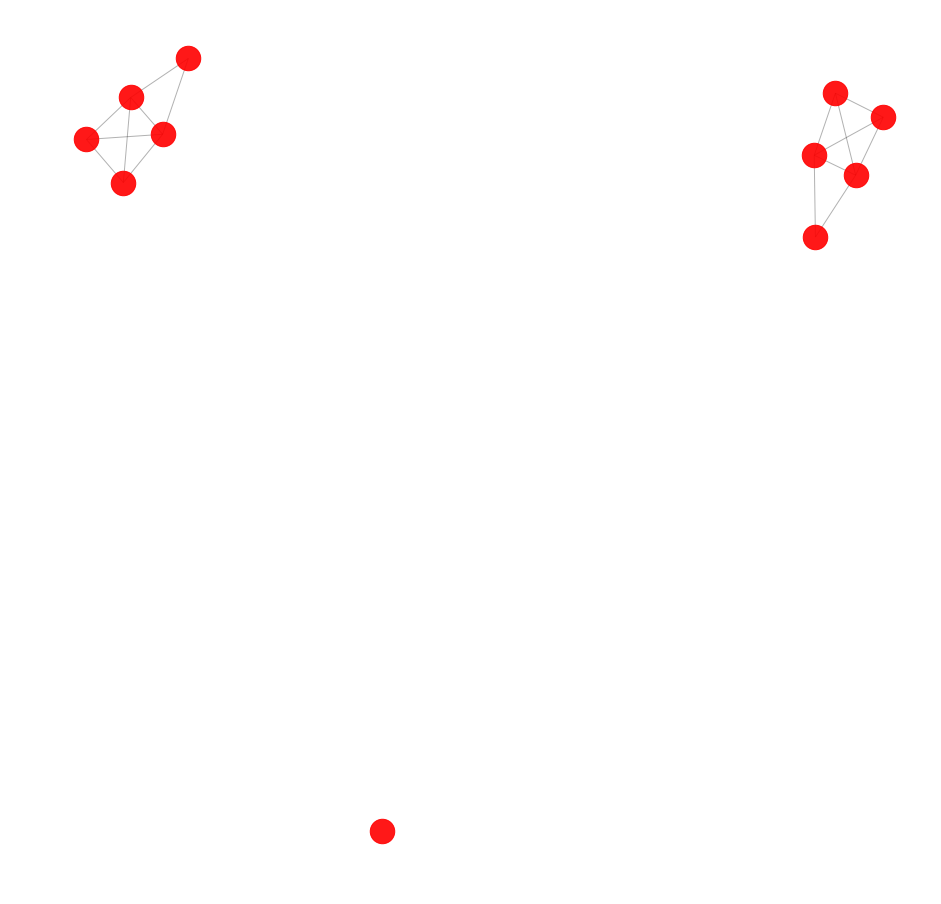

In [60]:
draw_graph(convert(res[0]))

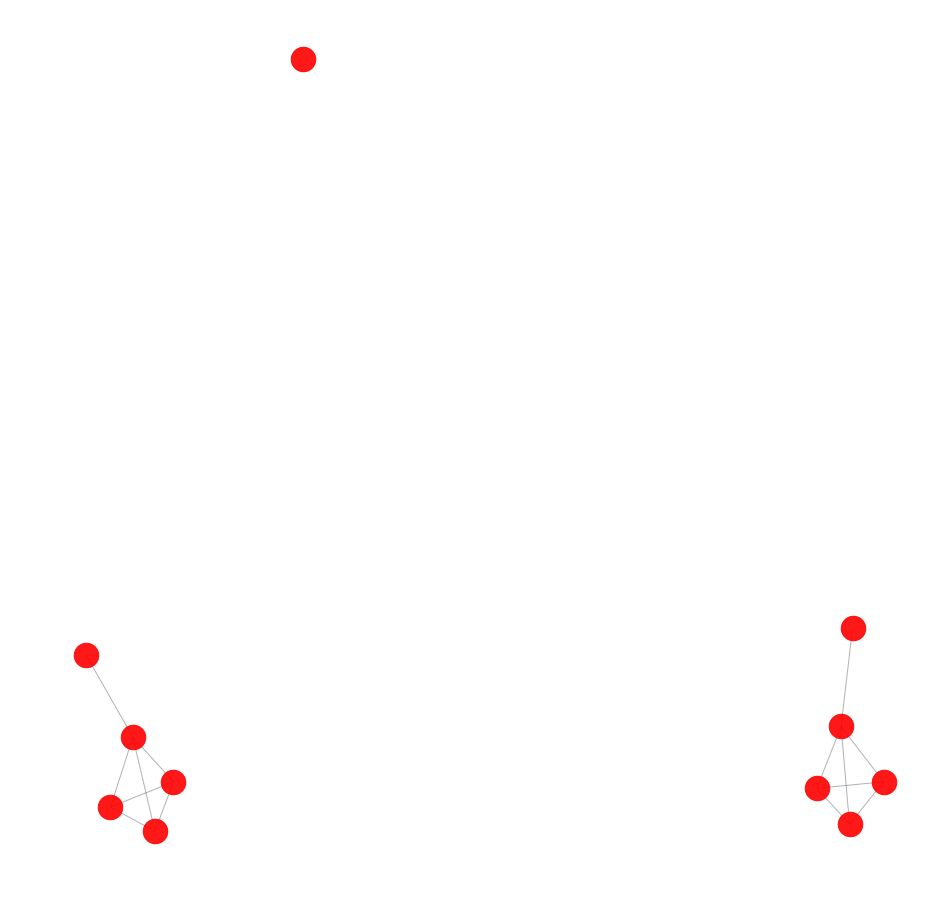

In [61]:
draw_graph(convert(res[1]))

In [23]:
def categorize(graph):
    n = graph.shape[0]
    
    color = -np.ones(n, int) #fill COLOR with -1
    current_color = 0
    nodes = np.array(range(n)) 
    
    while -1 in color:
        first = list(color).index(-1) #Finds the first occurence of -1 in the list
        index = [first]
        color[index]= current_color
        
        while len(index) != 0:
            index2 = []
            
            for node in index:

                for i in range(n):
                    if graph[node][i]>=0 and color[i] == -1:
                        index2.append(i)
                        color[i] = current_color
            
            index = index2
        current_color += 1
        
    part = {}
    for i in range(len(color)):
        part[i] = color[i]
    
        
    return part

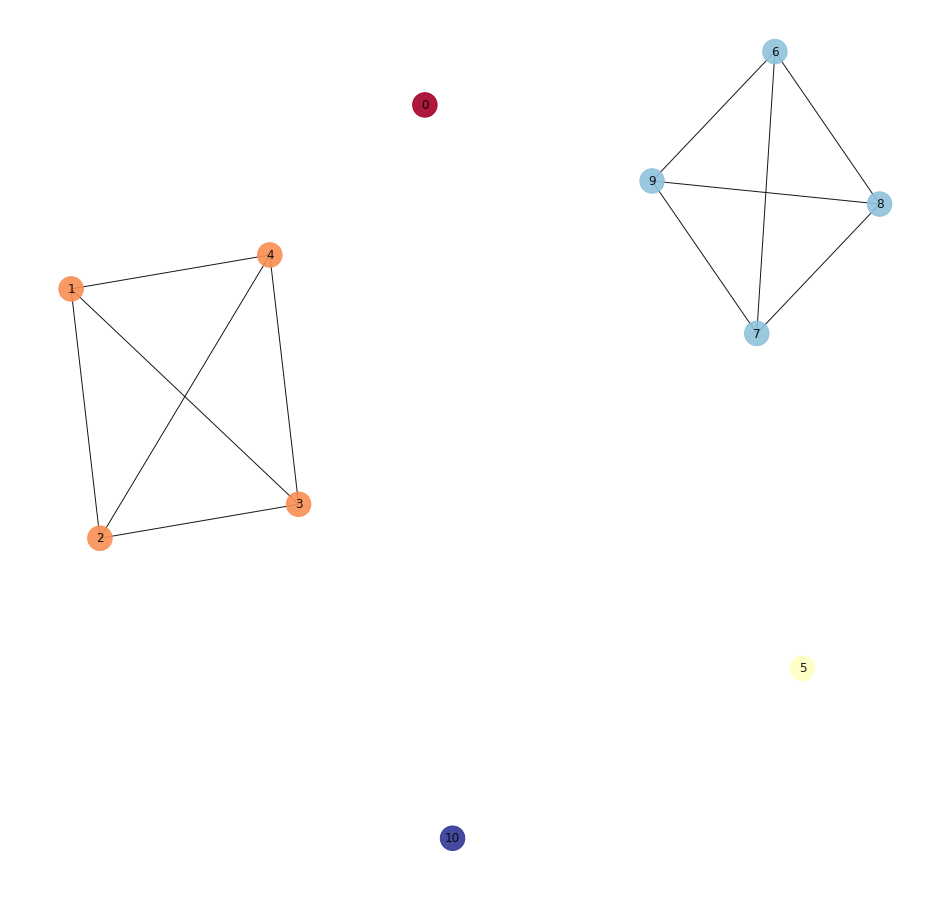

In [63]:
draw_partition(convert(res[2]),categorize(res[2]))

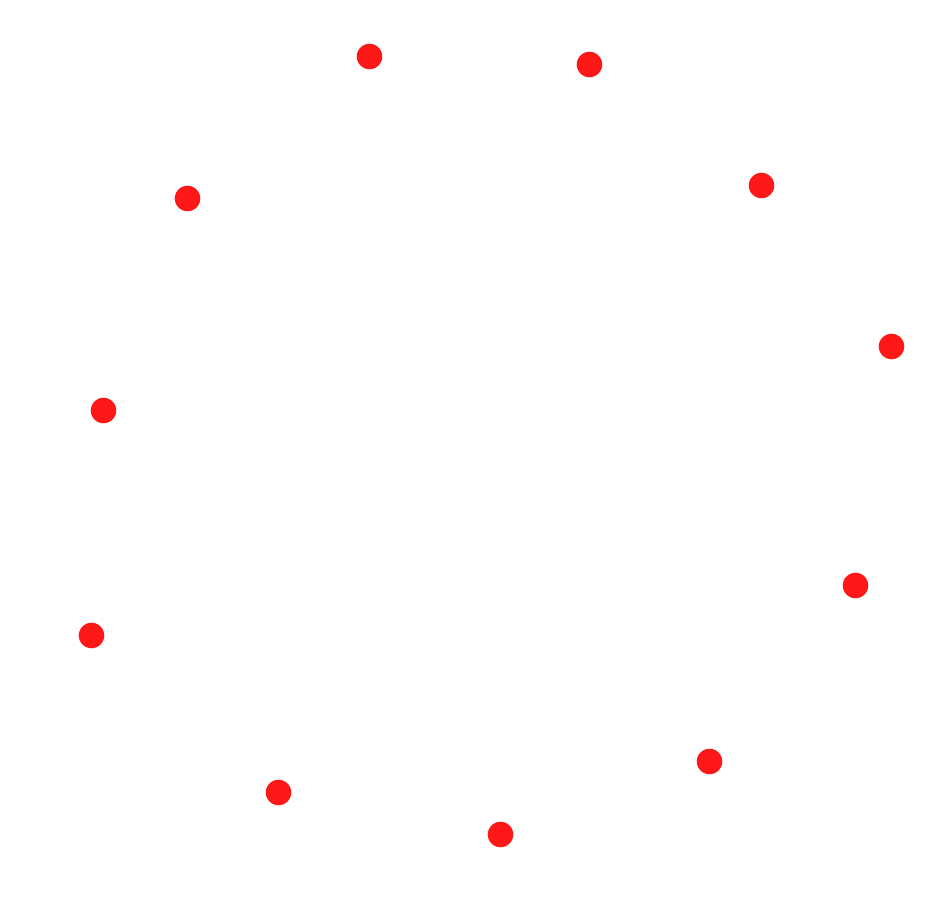

In [76]:
draw_graph(convert(res[3]))

In [64]:
G = nx.karate_club_graph()

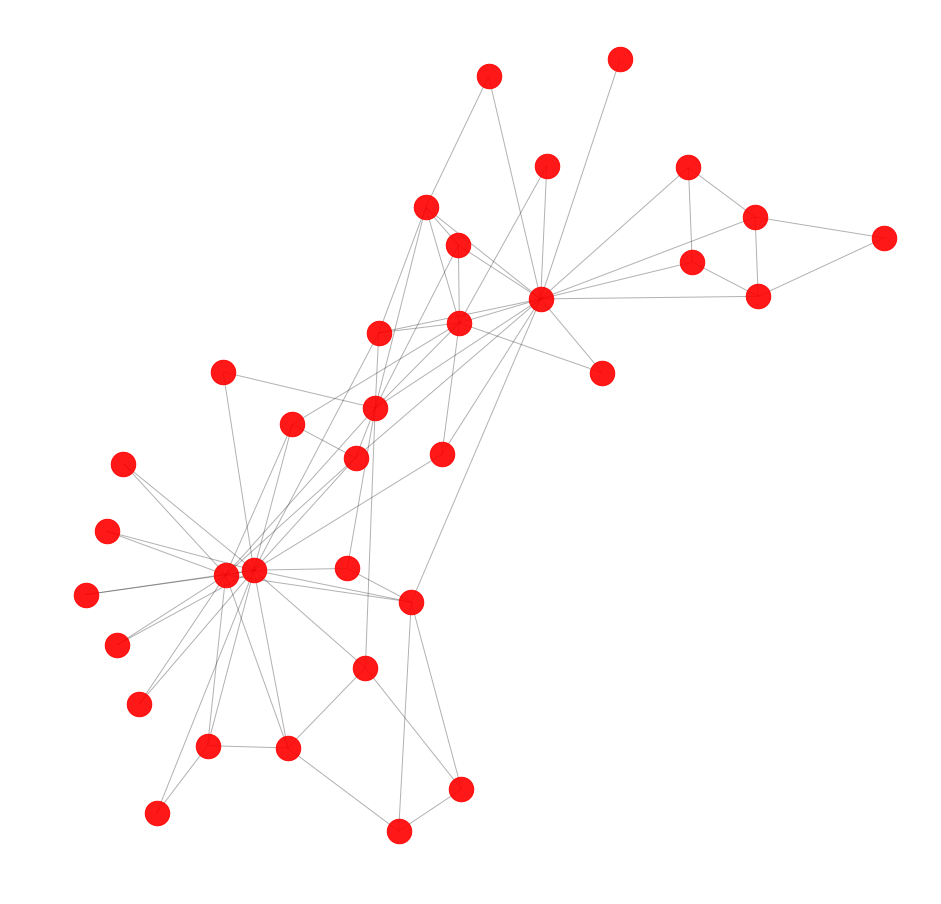

In [65]:
draw_graph(G)

In [66]:
G_adj =  nx.to_numpy_array(G)

In [67]:
G_adj

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [68]:
G_adj[G_adj == 0] = -1

In [69]:
G_adj[G_adj>0] = 0

In [70]:
result = summary(G_adj,20)

100%|█████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 737.89it/s]


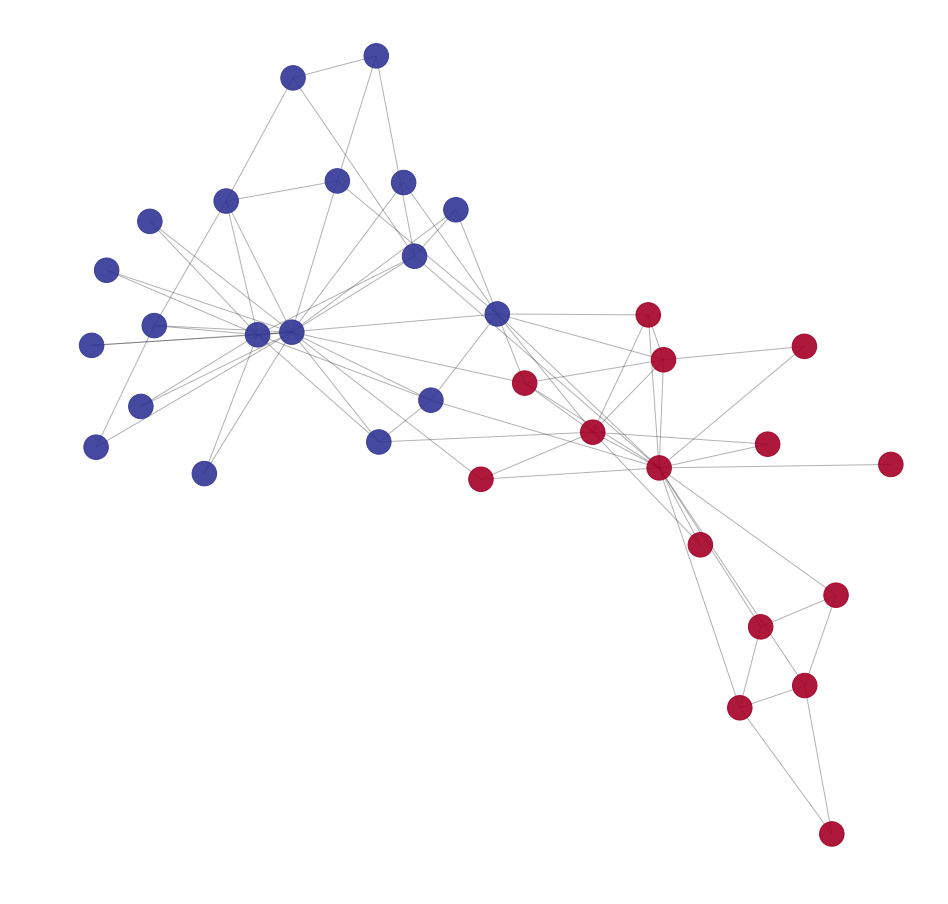

In [72]:
i = 10
draw_partition2(G,categorize(result[i]))